In [1]:
def read_quijote(filepath, cosm, snapnum, axis, space):
    """
    Returns array with Halo positions in Mpc/h
    """
    #import numpy as np
    import readgadget
    import readfof
    import redshift_space_library as RSL

    #-----------
    # Read data from Quijote
    #-----------

    # get the name of the corresponding snapshot
    snapshot = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/quijote/Snapshots/%s/0/snapdir_%03d/snap_%03d'%(cosm,snapnum,snapnum)
    
    # read the redshift, boxsize, cosmology...etc in the header
    header   = readgadget.header(snapshot)
    BoxSize  = header.boxsize/1e3  #Mpc/h
    #Nall     = header.nall         #Total number of particles
    #Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
    Omega_m  = header.omega_m      #value of Omega_m
    Omega_l  = header.omega_l      #value of Omega_l
    h        = header.hubble       #value of h
    redshift = header.redshift     #redshift of the snapshot
    Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l) #Value of H(z) in km/s/(Mpc/h)

    print(f'BoxSize = {BoxSize} Mpc/h')
    print(f'Omega_m = {Omega_m}')
    print(f'h = {h}')
    print(f'redshift = {redshift:.1f}')


    FoF = readfof.FoF_catalog(filepath, snapnum, long_ids=False,
                            swap=False, SFR=False, read_IDs=False)
    pos_h  = FoF.GroupPos/1e3            #Halo positions in Mpc/h
    vel_h  = FoF.GroupVel*(1.0+redshift) #Halo peculiar velocities in km/s

    if space == 'zspace':
    	RSL.pos_redshift_space(pos_h, vel_h, BoxSize, Hubble, redshift, axis)

    return pos_h, vel_h, BoxSize  #Halo positions in Mpc/h

import numpy as np

dir = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/quijote/Halos/FoF/fiducial/0/'

gxs = read_quijote(dir,'fiducial',4,0,'zspace')

BoxSize = 1000.0 Mpc/h
Omega_m = 0.3175
h = 0.6711
redshift = 0.0


In [2]:
import treecorr

pos = gxs[0]
x = pos[:,0]
y = pos[:,1]
z = pos[:,2]

cat = treecorr.Catalog(x=x, y=y, z=z)

In [3]:
import matplotlib.pyplot as plt

# Step 3: Create a random catalog (same number of particles, uniformly distributed in the same volume)
# You can adjust the limits of the random distribution as per your data's range.
N = len(x)*10
rand_x = np.random.uniform(np.min(x), np.max(x), N)
rand_y = np.random.uniform(np.min(y), np.max(y), N)
rand_z = np.random.uniform(np.min(z), np.max(z), N)

# Step 4: Create TreeCorr Catalogs for the data and random catalogs
data_cat = treecorr.Catalog(x=x, y=y, z=z)
random_cat = treecorr.Catalog(x=rand_x, y=rand_y, z=rand_z)

# Step 5: Set up NNCorrelation objects to calculate DD, RR, and DR pair counts
nn_data = treecorr.NNCorrelation(min_sep=10, max_sep=150, nbins=15, metric='Euclidean')
nn_random = treecorr.NNCorrelation(min_sep=10, max_sep=150, nbins=15, metric='Euclidean')
nn_cross = treecorr.NNCorrelation(min_sep=10, max_sep=150, nbins=15, metric='Euclidean')

# Step 6: Compute the pair counts
nn_data.process(data_cat)        # DD counts
nn_random.process(random_cat)    # RR counts
nn_cross.process(data_cat, random_cat)  # DR counts

# Step 7: Calculate the Landy-Szalay estimator for ξ(r)
r = np.exp(nn_data.meanlogr)  # Separation distances (logarithmic binning)
DD = nn_data.npairs
RR = nn_random.npairs
DR = nn_cross.npairs
xi = (DD - 2 * DR + RR) / RR

# Step 8: Output and plot the results
plt.plot(r, xi)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r (Mpc/h)')
plt.ylabel('ξ(r)')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


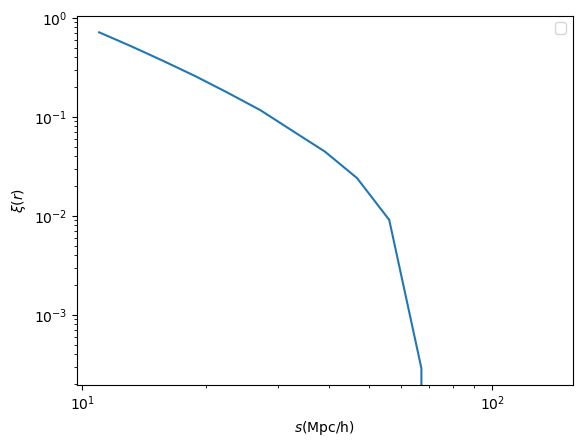

In [ ]:
import matplotlib.pyplot as plt

# Create a random catalog 
N = len(x)*10
rand_x = np.random.uniform(np.min(x), np.max(x), N)
rand_y = np.random.uniform(np.min(y), np.max(y), N)
rand_z = np.random.uniform(np.min(z), np.max(z), N)

# Create TreeCorr Catalogs for the data and random catalogs
data_cat = treecorr.Catalog(x=x, y=y, z=z)
random_cat = treecorr.Catalog(x=rand_x, y=rand_y, z=rand_z)

nn = treecorr.NNCorrelation(min_sep=10, max_sep=150, nbins=15, metric='Euclidean')
rr = treecorr.NNCorrelation(min_sep=10, max_sep=150, nbins=15, metric='Euclidean')
dr = treecorr.NNCorrelation(min_sep=10, max_sep=150, nbins=15, metric='Euclidean')

nn.process(data_cat)                # For auto-correlation.
rr.process(random_cat)              # Likewise for random-random correlations
dr.process(data_cat,random_cat)     # If desired, also do data-random correlations
xi,varxi = nn.calculateXi(rr=rr,dr=dr)  # Or get correlation function directly.


# Output and plot the results
plt.plot(r, xi)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$s$'+'(Mpc/h)')
plt.ylabel(r'$\xi(r)$')
plt.legend()
plt.show()

## Trying Corrfunc


In [1]:
import numpy as np
from Corrfunc.io import read_catalog

# Read the default galaxies supplied with
# Corrfunc. ~ 1 million galaxies on a 420 Mpc/h cube
X, Y, Z = read_catalog()

# Specify boxsize for the XYZ arrays
boxsize = 420.0

# Number of threads to use
nthreads = 2

# Create the bins array
rmin = 0.1
rmax = 20.0
nbins = 20
rbins = np.logspace(np.log10(rmin), np.log10(rmax), nbins + 1)

# Specify the distance to integrate along line of sight
pimax = 40.0

# Specify the max. of the cosine of the angle to the LOS for
# DD(s, mu)
mu_max = 1.0

# Specify the number of linear bins in `mu`
nmu_bins = 20

# Specify that an autocorrelation is wanted
autocorr = 1

In [3]:
from Corrfunc.theory.DDsmu import DDsmu
results_DDsmu = DDsmu(autocorr, nthreads, rbins, mu_max, nmu_bins, X, Y, Z, boxsize=boxsize)

In [11]:
results_DDsmu

array([( 0.1       ,  0.13033213, 0., 0.05,     6062, 0.),
       ( 0.1       ,  0.13033213, 0., 0.1 ,     6090, 0.),
       ( 0.1       ,  0.13033213, 0., 0.15,     6014, 0.),
       ( 0.1       ,  0.13033213, 0., 0.2 ,     6230, 0.),
       ( 0.1       ,  0.13033213, 0., 0.25,     6064, 0.),
       ( 0.1       ,  0.13033213, 0., 0.3 ,     6204, 0.),
       ( 0.1       ,  0.13033213, 0., 0.35,     6048, 0.),
       ( 0.1       ,  0.13033213, 0., 0.4 ,     5856, 0.),
       ( 0.1       ,  0.13033213, 0., 0.45,     6166, 0.),
       ( 0.1       ,  0.13033213, 0., 0.5 ,     5998, 0.),
       ( 0.1       ,  0.13033213, 0., 0.55,     6014, 0.),
       ( 0.1       ,  0.13033213, 0., 0.6 ,     5968, 0.),
       ( 0.1       ,  0.13033213, 0., 0.65,     6026, 0.),
       ( 0.1       ,  0.13033213, 0., 0.7 ,     6046, 0.),
       ( 0.1       ,  0.13033213, 0., 0.75,     5990, 0.),
       ( 0.1       ,  0.13033213, 0., 0.8 ,     6098, 0.),
       ( 0.1       ,  0.13033213, 0., 0.85,     5922, 0.

In [13]:
results_DDsmu['mu_max']

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 0.05, 0.1 ,
       0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65,
       0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 0.05, 0.1 , 0.15, 0.2 ,
       0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75,
       0.8 , 0.85, 0.9 , 0.95, 1.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ,
       0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85,
       0.9 , 0.95, 1.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ,
       0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95,
       1.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 0.05,
       0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 0.05, 0.1 , 0.15,
       0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.

#### Not sure how to follow

## Trying halotools

In [1]:
import numpy as np

Npts = 10000
Lbox = 250.

x = np.random.uniform(0, Lbox, Npts)
y = np.random.uniform(0, Lbox, Npts)
z = np.random.uniform(0, Lbox, Npts)

sample1 = np.vstack((x,y,z)).T

sample1

array([[226.03424017, 134.46681556, 148.22809968],
       [  7.74697921,  94.00700323, 110.82431043],
       [194.28146624, 210.55873844, 135.60150544],
       ...,
       [217.08009071,  29.47901368, 148.10705909],
       [142.73306444,   0.99595352, 141.22384996],
       [ 77.52396796,  73.21343505, 118.44027297]])

In [2]:
from halotools.mock_observables import s_mu_tpcf
from halotools.mock_observables import tpcf_multipole

s_bins  = np.linspace(0.01, 25, 10)
mu_bins = np.linspace(0, 1, 15)
xi_s_mu = s_mu_tpcf(sample1, s_bins, mu_bins, period=Lbox)

xi_0 = tpcf_multipole(xi_s_mu, mu_bins, order=0)
xi_2 = tpcf_multipole(xi_s_mu, mu_bins, order=2)
xi_4 = tpcf_multipole(xi_s_mu, mu_bins, order=4)



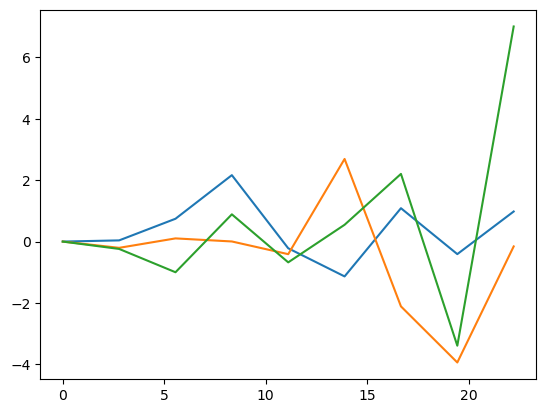

In [3]:
import matplotlib.pyplot as plt
nr = np.linspace(0.01, 25, 10)[:-1]

plt.plot(nr,(nr**2)*(xi_0))
plt.plot(nr,(nr**2)*(-xi_2))
plt.plot(nr,(nr**2)*(-xi_4))

In [4]:
def read_quijote(filepath, cosm, snapnum, axis, space):
    """
    Returns array with Halo positions in Mpc/h
    """
    #import numpy as np
    import readgadget
    import readfof
    import redshift_space_library as RSL

    #-----------
    # Read data from Quijote
    #-----------

    # get the name of the corresponding snapshot
    snapshot = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/quijote/Snapshots/%s/0/snapdir_%03d/snap_%03d'%(cosm,snapnum,snapnum)
    
    # read the redshift, boxsize, cosmology...etc in the header
    header   = readgadget.header(snapshot)
    BoxSize  = header.boxsize/1e3  #Mpc/h
    #Nall     = header.nall         #Total number of particles
    #Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
    Omega_m  = header.omega_m      #value of Omega_m
    Omega_l  = header.omega_l      #value of Omega_l
    h        = header.hubble       #value of h
    redshift = header.redshift     #redshift of the snapshot
    Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l) #Value of H(z) in km/s/(Mpc/h)

    print(f'BoxSize = {BoxSize} Mpc/h')
    print(f'Omega_m = {Omega_m}')
    print(f'h = {h}')
    print(f'redshift = {redshift:.1f}')


    FoF = readfof.FoF_catalog(filepath, snapnum, long_ids=False,
                            swap=False, SFR=False, read_IDs=False)
    pos_h  = FoF.GroupPos/1e3            #Halo positions in Mpc/h
    vel_h  = FoF.GroupVel*(1.0+redshift) #Halo peculiar velocities in km/s

    if space == 'zspace':
    	RSL.pos_redshift_space(pos_h, vel_h, BoxSize, Hubble, redshift, axis)

    return pos_h, vel_h, BoxSize  #Halo positions in Mpc/h

import numpy as np

dir = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/quijote/Halos/FoF/fiducial/0/'

gxs = read_quijote(dir,'fiducial',4,0,'zspace')

BoxSize = 1000.0 Mpc/h
Omega_m = 0.3175
h = 0.6711
redshift = 0.0


In [6]:
gxs[2]

1000.0

In [10]:
sample1 = gxs[0]

s_bins  = np.linspace(10, 150, 21)
mu_bins = np.linspace(0, 1, 51)
xi_s_mu = s_mu_tpcf(sample1, s_bins, mu_bins, period=gxs[2])

xi_0 = tpcf_multipole(xi_s_mu, mu_bins, order=0)
xi_2 = tpcf_multipole(xi_s_mu, mu_bins, order=2)
xi_4 = tpcf_multipole(xi_s_mu, mu_bins, order=4)

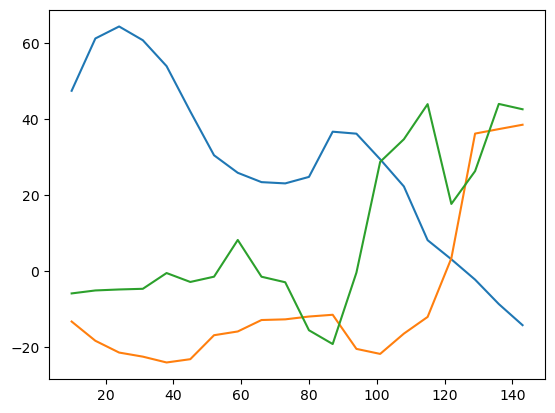

In [11]:
import matplotlib.pyplot as plt
nr = s_bins[:-1]

plt.plot(nr,(nr**2)*(xi_0))
plt.plot(nr,(nr**2)*(-xi_2))
plt.plot(nr,(nr**2)*(-xi_4))

### can't install readgadget (pylians) in the nbodykit env

## Trying Pycorr

#### can't install pycorr in vpf env
